 Cellule 1 – Setup environnement + GPU + seeds

In [1]:
# ============================================
# 1. Setup environnement & GPU
# ============================================
import os, random, numpy as np, tensorflow as tf

print("TensorFlow version:", tf.__version__)

# Vérifier le GPU
!nvidia-smi

# Fixer les seeds pour un comportement plus stable
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

TensorFlow version: 2.19.0
Wed Nov 19 20:14:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------------------

Cellule 2 – Télécharger le dataset Kaggle

In [2]:
# ============================================
# 2. Télécharger le dataset Kaggle si besoin
#    Dataset : paultimothymooney/chest-xray-pneumonia
# ============================================
DATASET_DIR = "/content/chest_xray"

if not os.path.exists(DATASET_DIR):
    from google.colab import files

    print("➡️ Uploade ton fichier kaggle.json (My Account > API > Create new token)...")
    files.upload()  # sélectionne kaggle.json

    # Configurer Kaggle
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    # Télécharger le dataset
    !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content

    # Dézipper
    !unzip -q "/content/chest-xray-pneumonia.zip" -d /content

else:
    print(f"✅ Dataset déjà présent : {DATASET_DIR}")

➡️ Uploade ton fichier kaggle.json (My Account > API > Create new token)...


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.26G/2.29G [00:54<00:02, 15.7MB/s]
100% 2.29G/2.29G [00:54<00:00, 45.2MB/s]


 Cellule 3 – Chemins & statistiques du dataset

In [3]:
# ============================================
# 3. Chemins & stats basiques du dataset
# ============================================
from glob import glob

dataset_path = "/content/chest_xray"
train_dir = os.path.join(dataset_path, "train")
val_dir   = os.path.join(dataset_path, "val")
test_dir  = os.path.join(dataset_path, "test")

print("Train dir:", train_dir)
print("Val   dir:", val_dir)
print("Test  dir:", test_dir)

def count_images(folder):
    normal = len(glob(os.path.join(folder, "NORMAL", "*.jpeg"))) + len(glob(os.path.join(folder, "NORMAL", "*.jpg")))
    pneu   = len(glob(os.path.join(folder, "PNEUMONIA", "*.jpeg"))) + len(glob(os.path.join(folder, "PNEUMONIA", "*.jpg")))
    return normal, pneu

train_normal, train_pneu = count_images(train_dir)
val_normal, val_pneu     = count_images(val_dir)
test_normal, test_pneu   = count_images(test_dir)

print(f"\n🧾 Train  : NORMAL={train_normal}, PNEUMONIA={train_pneu}")
print(f"🧾 Val    : NORMAL={val_normal},   PNEUMONIA={val_pneu}")
print(f"🧾 Test   : NORMAL={test_normal},  PNEUMONIA={test_pneu}")

Train dir: /content/chest_xray/train
Val   dir: /content/chest_xray/val
Test  dir: /content/chest_xray/test

🧾 Train  : NORMAL=1341, PNEUMONIA=3875
🧾 Val    : NORMAL=8,   PNEUMONIA=8
🧾 Test   : NORMAL=234,  PNEUMONIA=390


Cellule 4 – Data generators + normalisation cohérente avec ton app

In [4]:
# ============================================
# 4. Data generators (ImageDataGenerator)
#    Normalisation = (x / 127.5) - 1  pour matching Streamlit
# ============================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT = 224
IMG_WIDTH  = 224
BATCH_SIZE = 32

# Data augmentation avancée pour le train
train_datagen = ImageDataGenerator(
    rescale=1.0 / 127.5,
    preprocessing_function=lambda x: x - 1.0,
    rotation_range=15,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.10,
    zoom_range=0.10,
    horizontal_flip=True,
)

# Validation / Test : même normalisation, sans augmentation
val_test_datagen = ImageDataGenerator(
    rescale=1.0 / 127.5,
    preprocessing_function=lambda x: x - 1.0,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary",
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,
)

print("\nClasses (train) :", train_generator.class_indices)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

Classes (train) : {'NORMAL': 0, 'PNEUMONIA': 1}


Cellule 5 – class_weight pour corriger le déséquilibre

In [5]:
# ============================================
# 5. Class weights – correction du dataset déséquilibré
# ============================================
from sklearn.utils.class_weight import compute_class_weight

y_train = train_generator.classes  # vecteur de 0/1

class_weights_values = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train,
)

class_weights = {i: w for i, w in enumerate(class_weights_values)}
print("⚖️ Class weights calculés :", class_weights)

⚖️ Class weights calculés : {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


Cellule 6 – Focal Loss (option avancée pour classes déséquilibrées)


In [6]:
# ============================================
# 6. Focal Loss binaire (option avancée)
# ============================================
def binary_focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal loss binaire pour déséquilibre de classes.
    gamma > 1 down-weight les exemples faciles.
    alpha contrôle l'importance de la classe minoritaire.
    """
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow(1.0 - p_t, gamma)

        return tf.reduce_mean(alpha_factor * modulating_factor * bce)
    return loss

focal_loss = binary_focal_loss(gamma=2.0, alpha=0.25)
print("✅ Focal loss définie.")

✅ Focal loss définie.


 Cellule 7 – Modèle DenseNet121 (backbone radiologie classique)

In [7]:
# ============================================
# 7. Modèle DenseNet121 – backbone médical
# ============================================
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models

base_model = DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
)

base_model.trainable = False  # Phase 1 : on gèle le backbone

inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs, name="Pneumonia_DenseNet121")

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Pneumonia_DenseNet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Cellule 8 – Optimiseur (AdamW si dispo) + compilation

In [8]:
# ============================================
# 8. Compilation du modèle (AdamW si dispo, sinon Adam)
# ============================================
from tensorflow.keras import optimizers

try:
    from tensorflow.keras.optimizers import AdamW
    optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-5)
    print("✅ Utilisation de AdamW (avec weight decay)")
except Exception:
    optimizer = optimizers.Adam(learning_rate=1e-4)
    print("ℹ️ AdamW indisponible, fallback vers Adam classique.")

USE_FOCAL = True  # mets False si tu veux du BCE classique

loss_fn = focal_loss if USE_FOCAL else "binary_crossentropy"

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=["accuracy"],
)

print("✅ Modèle compilé avec", "Focal Loss" if USE_FOCAL else "Binary Crossentropy")

✅ Utilisation de AdamW (avec weight decay)
✅ Modèle compilé avec Focal Loss


Cellule 9 – Callbacks + Phase 1 training (backbone gelé)

In [9]:
# ============================================
# 9. Entraînement – Phase 1 (backbone gelé)
# ============================================
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_path_phase1 = "/content/best_pneumonia_densenet_phase1.h5"

callbacks_phase1 = [
    ModelCheckpoint(
        checkpoint_path_phase1,
        monitor="val_accuracy",
        save_best_only=True,
        mode="max",
        verbose=1,
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1,
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=2,
        min_lr=1e-6,
        verbose=1,
    ),
]

EPOCHS_PHASE1 = 10

history_phase1 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE1,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks_phase1,
    verbose=1,
)

print("✅ Phase 1 terminée.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.5318 - loss: 0.1296
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to /content/best_pneumonia_densenet_phase1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 146s 716ms/step - accuracy: 0.5320 - loss: 0.1295 - val_accuracy: 0.5625 - val_loss: 0.1688 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.6230 - loss: 0.0782
Epoch 2: val_accuracy did not improve from 0.56250
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 607ms/step - accuracy: 0.6232 - loss: 0.0781 - val_accuracy: 0.5000 - val_loss: 0.1117 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.6869 - loss: 0.0537
Epoch 3: val_accuracy improved from 0.56250 to 0.62500, saving model to /content/best_pneumonia_densenet_phase1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 613ms/step - accuracy: 0.6870 - loss: 0.0537 - val_accuracy: 0.6250 - val_loss: 0.0815 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.7447 - loss: 0.0400
Epoch 4: val_accuracy did not improve from 0.62500
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 612ms/step - accuracy: 0.7448 - loss: 0.0400 - val_accuracy: 0.6250 - val_loss: 0.0661 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.7793 - loss: 0.0323
Epoch 5: val_accuracy improved from 0.62500 to 0.68750, saving model to /content/best_pneumonia_densenet_phase1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 615ms/step - accuracy: 0.7793 - loss: 0.0323 - val_accuracy: 0.6875 - val_loss: 0.0561 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.8022 - loss: 0.0277
Epoch 6: val_accuracy improved from 0.68750 to 0.81250, saving model to /content/best_pneumonia_densenet_phase1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 612ms/step - accuracy: 0.8022 - loss: 0.0277 - val_accuracy: 0.8125 - val_loss: 0.0454 - learning_rate: 1.0000e-04
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.8187 - loss: 0.0234
Epoch 7: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 611ms/step - accuracy: 0.8187 - loss: 0.0234 - val_accuracy: 0.8125 - val_loss: 0.0409 - learning_rate: 1.0000e-04
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.8352 - loss: 0.0206
Epoch 8: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 609ms/step - accuracy: 0.8352 - loss: 0.0205 - val_accuracy: 0.8125 - val_loss: 0.0394 - learning_rate: 1.0000e-04
Epoch 9/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.8398 - loss: 0.0190
Epoch 9: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 606ms/step - accuracy: 0.8398 - loss: 0.0190 - val_accuracy: 0.7500 - val_loss: 0.0357 - learning_rate: 

Cellule 10 – Fine-tuning : on dégele le haut de DenseNet

In [10]:
# ============================================
# 10. Fine-tuning – Phase 2 (dégel partiel)
# ============================================

# Charger les meilleurs poids de la phase 1
model.load_weights(checkpoint_path_phase1)

# On dégèle les 40 dernières couches du backbone
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

# On réduit un peu le LR pour le fine-tuning
optimizer_ft = optimizers.Adam(learning_rate=1e-5)

model.compile(
    optimizer=optimizer_ft,
    loss=loss_fn,
    metrics=["accuracy"],
)

checkpoint_path_phase2 = "/content/best_pneumonia_densenet_phase2.h5"

callbacks_phase2 = [
    ModelCheckpoint(
        checkpoint_path_phase2,
        monitor="val_accuracy",
        save_best_only=True,
        mode="max",
        verbose=1,
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=4,
        restore_best_weights=True,
        verbose=1,
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=2,
        min_lr=1e-6,
        verbose=1,
    ),
]

EPOCHS_PHASE2 = 8

history_phase2 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE2,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks_phase2,
    verbose=1,
)

print("✅ Phase 2 terminée.")

Epoch 1/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.8406 - loss: 0.0183
Epoch 1: val_accuracy improved from -inf to 0.81250, saving model to /content/best_pneumonia_densenet_phase2.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 145s 687ms/step - accuracy: 0.8407 - loss: 0.0183 - val_accuracy: 0.8125 - val_loss: 0.0259 - learning_rate: 1.0000e-05
Epoch 2/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.8669 - loss: 0.0121
Epoch 2: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 614ms/step - accuracy: 0.8669 - loss: 0.0121 - val_accuracy: 0.8125 - val_loss: 0.0194 - learning_rate: 1.0000e-05
Epoch 3/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.8819 - loss: 0.0093
Epoch 3: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 609ms/step - accuracy: 0.8819 - loss: 0.0093 - val_accuracy: 0.8125 - val_loss: 0.0174 - learning_rate: 1.0000e-05
Epoch 4/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.8999 - loss: 0.0081
Epoch 4: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 617ms/step - accuracy: 0.8999 - loss: 0.0081 - val_accuracy: 0.8125 - val_loss: 0.0157 - learning_rate: 1.

Cellule 11 – Courbes d’apprentissage (loss + accuracy)

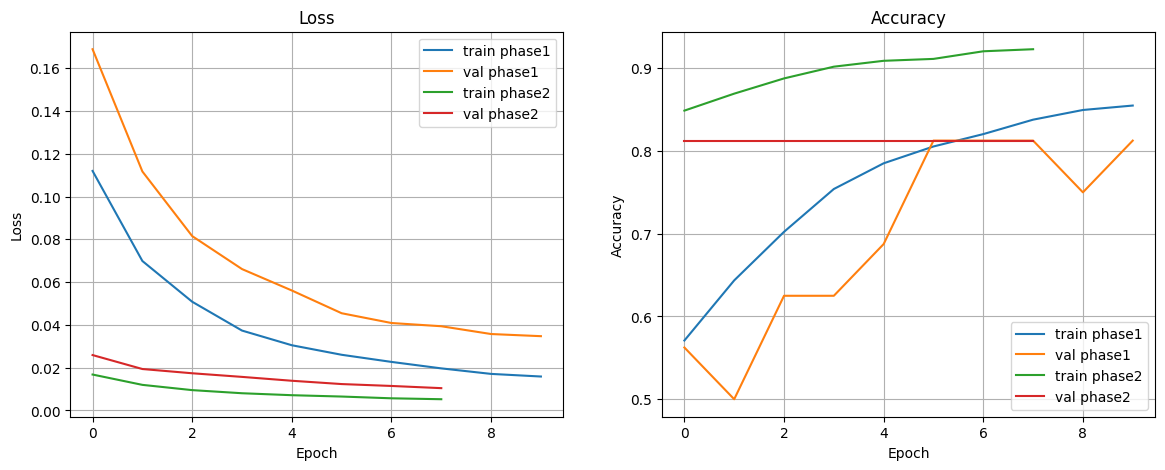

In [11]:
# ============================================
# 11. Courbes d'apprentissage
# ============================================
import matplotlib.pyplot as plt

def plot_history(histories, labels):
    plt.figure(figsize=(14,5))

    # Loss
    plt.subplot(1,2,1)
    for h, lbl in zip(histories, labels):
        plt.plot(h.history["loss"], label=f"train {lbl}")
        plt.plot(h.history["val_loss"], label=f"val {lbl}")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1,2,2)
    for h, lbl in zip(histories, labels):
        plt.plot(h.history["accuracy"], label=f"train {lbl}")
        plt.plot(h.history["val_accuracy"], label=f"val {lbl}")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.show()

plot_history([history_phase1, history_phase2], ["phase1", "phase2"])

Cellule 12 – Évaluation complète sur le test (accuracy, F1, AUC)

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - accuracy: 0.8782 - loss: 0.0348

📊 Test accuracy: 90.06%
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 802ms/step

Matrice de confusion :
[[199  35]
 [ 27 363]]

Rapport de classification :
              precision    recall  f1-score   support

      NORMAL       0.88      0.85      0.87       234
   PNEUMONIA       0.91      0.93      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624



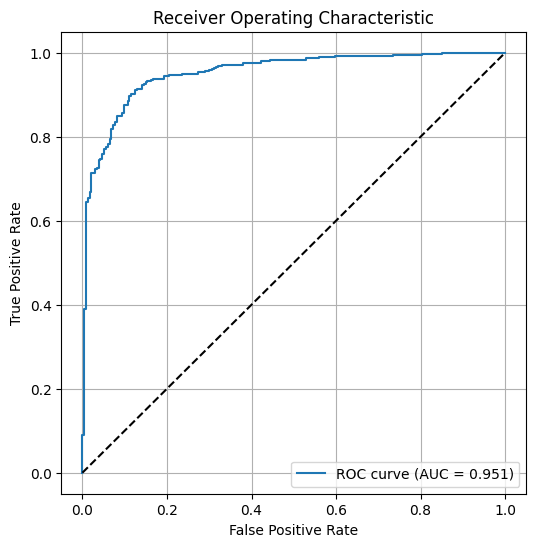

In [12]:
# ============================================
# 12. Évaluation sur le set de test
# ============================================
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"\n📊 Test accuracy: {test_acc*100:.2f}%")

# Prédictions
test_generator.reset()
y_prob = model.predict(test_generator, verbose=1).ravel()
y_pred = (y_prob >= 0.5).astype(int)
y_true = test_generator.classes

print("\nMatrice de confusion :")
print(confusion_matrix(y_true, y_pred))

print("\nRapport de classification :")
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Cellule 13 – Sauvegarde modèle + labels pour Streamlit

In [13]:
# ============================================
# 13. Sauvegarde modèle & labels.txt (pour Streamlit)
# ============================================
model_save_path = "/content/pneumonia_classifier.h5"
labels_save_path = "/content/labels.txt"

model.save(model_save_path)
print(f"💾 Modèle sauvegardé : {model_save_path}")

class_indices = train_generator.class_indices  # ex: {'NORMAL':0, 'PNEUMONIA':1}
labels = {v: k for k, v in class_indices.items()}

with open(labels_save_path, "w") as f:
    for idx, label in labels.items():
        f.write(f"{idx} {label}\n")

print(f"💾 Labels sauvegardés : {labels_save_path}")
print("Labels :", labels)

from google.colab import files
files.download(model_save_path)
files.download(labels_save_path)

💾 Modèle sauvegardé : /content/pneumonia_classifier.h5
💾 Labels sauvegardés : /content/labels.txt
Labels : {0: 'NORMAL', 1: 'PNEUMONIA'}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cellule 14 – Grad-CAM pour DenseNet121 (explicabilité)

In [1]:
# ============================================
# 14. Grad-CAM – visualisation des zones importantes
# ============================================
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as kimage

# Nom de la dernière couche convolutionnelle dans DenseNet121
last_conv_layer_name = "conv5_block16_concat"

def get_img_array(img_path, size=(IMG_WIDTH, IMG_HEIGHT)):
    img = kimage.load_img(img_path, target_size=size)
    arr = kimage.img_to_array(img).astype(np.float32)
    arr = (arr / 127.5) - 1.0  # même normalisation Streamlit
    return np.expand_dims(arr, axis=0), img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output],
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]   # proba PNEUMONIA

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, alpha=0.4):
    img_array, original_img = get_img_array(img_path)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    heatmap_resized = cv2.resize(heatmap, (original_img.size[0], original_img.size[1]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(
        cv2.cvtColor(np.array(original_img), cv2.COLOR_RGB2BGR), 1 - alpha,
        heatmap_color,
        alpha,
        0,
    )

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Image originale")
    plt.imshow(original_img)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Grad-CAM (zones importantes)")
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Exemple : une image PNEUMONIA du test
from glob import glob
example_pneu = glob(os.path.join(test_dir, "PNEUMONIA", "*.jpeg"))[0]
example_normal = glob(os.path.join(test_dir, "NORMAL", "*.jpeg"))[0]

print("Exemple PNEUMONIA :", example_pneu)
display_gradcam(example_pneu)

print("Exemple NORMAL :", example_normal)
display_gradcam(example_normal)

NameError: name 'IMG_WIDTH' is not defined